In [2]:
from pybedtools import BedTool
import pandas as pd

mm9 = pd.read_csv(
    '/groups/mm9_assembly.tsv', 
    sep = '\t', 
    usecols = [1, 2, 3], 
    skiprows = 1, 
    header = None, 
    names = ['chrom', 'start', 'end']
)
mm9.sort_values(
    by = ['chrom', 'start', 'end'],
    inplace = True
)
bt = BedTool().from_dataframe(mm9)
mm9 = bt.merge()
mm9.head()

chr1	3000000	22414948
 chr1	22415048	22423349
 chr1	22473349	24686638
 chr1	24736638	75102130
 chr1	75118130	78603540
 chr1	78603640	78604724
 chr1	78605669	78606725
 chr1	78607360	78610454
 chr1	78610737	85343678
 chr1	87343678	145296547
 

In [4]:
#for excluding N-stretches from the bedgraphs
import pyBigWig as pb
conditions = ['lacz', 'mcmkd', 'rifkolacz', 'rifkomcmkd']

chroms = pd.read_csv(
    'mm9.chr_lengths.txt', 
    sep = '\t', 
    header = None, 
    names = ['chrom', 'size']
).sort_values(by = 'chrom')

mm9_chroms = [(c, s) for c, s in chroms.values]
for cond in conditions:
    print(cond)
    bg_df = pd.read_csv(
        f'bedgraphs/{cond}_rt_20kb.bg', 
        sep = '\t', 
        header = None, 
        names = ['chrom', 'start', 'end', 'value']
    ).sort_values(by = ['chrom', 'start', 'end']) \
    .reset_index(drop = True)
    bg_bt = BedTool().from_dataframe(bg_df)
    bg_df = bg_bt \
        .intersect(mm9, u = True) \
        .to_dataframe(names = ['chrom', 'start', 'end', 'value'])

    bw = pb.open(f'bigwigs/{cond}_rt_20kb.bw', 'w')
    bw.addHeader(mm9_chroms)
    bw.addEntries(
        list(bg_df.chrom.values), 
        list(bg_df.start.values), 
        ends = list(bg_df.end.values), 
        values = list(bg_df.value.values)
    )
    bw.close()

lacz
mcmkd
rifkolacz
rifkomcmkd


In [7]:
import numpy as np
def read_bg_and_add_bw(bg, bw):
    df = pd.read_csv(bg, 
                     header = None,
                     usecols = [0, 1, 2, 3],
                     names = ['chrom', 'start', 'end', 'domain'],
                     sep = '\t')
    
    bw = pb.open(bw)
    
    def get_mean_bw_value(x, bw):
        intervals = bw.intervals(x['chrom'], x['start'], x['end'])
        values = np.array([i[-1] for i in intervals])
        return values.mean()
    
    df['bw_value'] = df.apply(get_mean_bw_value, axis = 1, bw = bw)
    return df


def assign_domain_names(df, names, split_domain = {}):
    '''
    names has to contain the expected domain names in the order from low value to high value
    split_domains takes a dictionary with the domain_names as keys and a tuple containing 
    (split_value, smaller_split_name, greater_split_name)
    '''
    domains = []
    for domain, group in df.groupby('domain'):
        domains.append((group.bw_value.mean(), domain))
    
    domains = sorted(domains, key = lambda x: x[0])
    domain2name = {domain[1]: name for domain, name in zip(domains, names)}
    
    df['domain_name'] = df.domain.apply(lambda x: domain2name[x])
    
    if split_domain:
        for domain_name, (split_value, smaller_split_name, greater_split_name) in split_domain.items():
            df.loc[(df.domain_name == domain_name) & (df.bw_value < split_value), 'domain_name'] = smaller_split_name
            df.loc[(df.domain_name == domain_name) & (df.bw_value >= split_value), 'domain_name'] = greater_split_name
    
    return df


hmms = {
    cond: read_bg_and_add_bw(
        f'hmm/{cond}_rt_20kb_3_state_HMM_colored.bed', 
        f'bigwigs/{cond}_rt_20kb.bw') 
    for cond in conditions
}
domain_names = ['L', 'M', 'E']
for cond in conditions:
    hmms[cond]['length'] = hmms[cond].end - hmms[cond].start
    hmms[cond] = assign_domain_names(
        hmms[cond], 
        domain_names
    )

In [10]:
def expand_bins(df, resolution, value_col):
    df = df.copy()
    expandables = (df.end - df.start) > resolution
    expanded = []
    for i, bin_ in df[expandables].iterrows():
        for j in range((bin_['end'] - bin_['start'])//resolution):
            expanded.append([bin_['chrom'], 
                             bin_['start'] + resolution*j, 
                             bin_['start'] + resolution*(j+1), bin_[value_col]])
            
    df.drop(df[expandables].index, axis = 'index', inplace = True)
    
    expandedDf = pd.DataFrame(expanded,
                              columns = ['chrom', 'start', 'end', value_col])
    
    df = df.merge(expandedDf, 
                  on = ['chrom', 'start', 'end'], 
                  how = 'outer',
                  sort = True) \
           .rename(columns = {value_col + '_x': value_col})
    
    df.loc[:, value_col] = df[value_col].fillna(df[value_col + '_y'])
    return df.drop(value_col + '_y', axis = 'columns')


expanded_hmms = {}
bwfile = 'bigwigs/{0}_rt_20kb.bw'
for cond in conditions:
    print(cond)
    df = expand_bins(
        hmms[cond], 
        20000, 
        'domain_name'
    )

    bw = pb.open(bwfile.format(cond))

    def get_bw_value(x, bw):
        interval = bw.intervals(x.chrom, x.start, x.end)
        return interval[0][-1] if interval else np.nan

    df.loc[:, 'bw_value'] = df.apply(
        get_bw_value, 
        axis = 1, 
        bw = bw
    )
    expanded_hmms[cond] = df.loc[~df.bw_value.isna()]

lacz
mcmkd
rifkolacz
rifkomcmkd


In [11]:
def split_and_relabel_domain(df, old_domain, split_domains, split_value):
    df = df.copy()
    group_df = df.groupby('domain_name')
    group = group_df.get_group(old_domain)
    loweridx = group[group.bw_value < split_value].index
    higheridx = group[group.bw_value >= split_value].index
    
    for index, new_name in zip([loweridx, higheridx], split_domains):
        df.loc[index, 'domain_name'] = new_name
        
    return df

renamed_hmms = {}
split_domains = ('L-like', 'E-like')
for cond in conditions:
    renamed_hmms[cond] = split_and_relabel_domain(
        expanded_hmms[cond], 
        'M', 
        split_domains, 
        0
    )

In [12]:
renamed_hmms

{'lacz':        chrom      start        end  domain  bw_value   length domain_name
 0       chr1    3000000    3020000     NaN -2.237077      NaN           L
 1       chr1    3020000    3040000     NaN -2.300855      NaN           L
 2       chr1    3040000    3060000     NaN -2.349630      NaN           L
 3       chr1    3060000    3080000     NaN -2.384971      NaN           L
 4       chr1    3080000    3100000     NaN -2.405668      NaN           L
 ...      ...        ...        ...     ...       ...      ...         ...
 120729  chr9  123980000  124000000     NaN  3.857352      NaN           E
 120730  chr9  124000000  124020000     NaN  3.738373      NaN           E
 120731  chr9  124020000  124040000     NaN  3.562510      NaN           E
 120732  chr9  124040000  124060000     NaN  3.327174      NaN           E
 120733  chr9  124060000  124076172     1.0  3.034738  16172.0      E-like
 
 [120030 rows x 7 columns],
 'mcmkd':        chrom      start        end  domain  bw_value

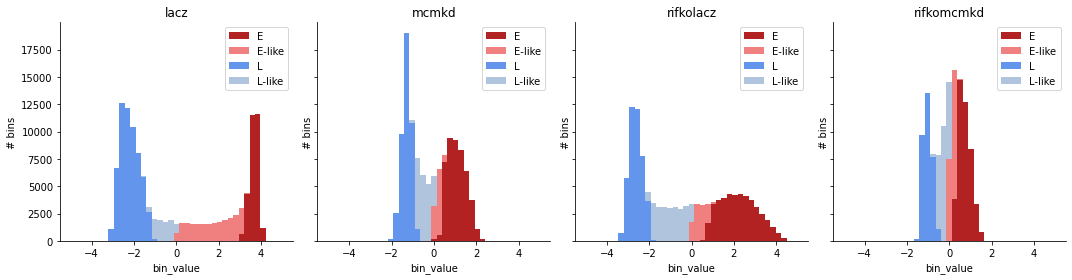

In [29]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42

fig, axs = plt.subplots(1, 4, sharey = 'row')
import seaborn as sb
xlims = {
    'lacz': (-5, 5), 
    'mcmkd': (-5, 5), 
    'rifkolacz': (-5, 5), 
    'rifkomcmkd': (-5, 5)
}
# colors = {
#     'E': 'firebrick', 
#     'E-like': 'lightcoral', 
#     'L' : 'cornflowerblue', 
#     'L-like': 'lightsteelblue'
# }
colors = ['firebrick', 'lightcoral', 'cornflowerblue', 'lightsteelblue']
for ax, cond in zip(axs, conditions):
    df = renamed_hmms[cond]
    x, domains = [], []
    for domain, group in df.groupby(f'domain_name'):
        domains.append(domain)
        x.append(group[f'bw_value'].values)

    ax.hist(
        x, 
        np.linspace(*xlims[cond], 40), 
        stacked = True,
        label = domains,
        color = colors[:len(domains)]
    )

    ax.legend()
    ax.set_title(f'{cond}')
    ax.set_xlabel('bin_value')
    ax.set_ylabel('# bins')

    for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)

fig.set_figwidth(15)
fig.set_figheight(4)
fig.tight_layout()
fig.savefig('rt_hmm_partition.pdf')

In [24]:
from pybedtools import BedTool
from functools import reduce

merged_hmms = {}
for cond in conditions:
    df1 = hmms[cond].loc[:, ['chrom', 'start', 'end', 'domain', 'length']]
    df1.sort_values(by = ['chrom', 'start', 'end'], inplace = True)
    df1_columns = ['chrom', 'start', 'end', 'domain', 'length']
    intersects = []
    for othercond in conditions:
        print(othercond)
        df2 = renamed_hmms[othercond].loc[:, ['chrom', 'start', 'end', 'bw_value', 'domain_name']]
        for new_col, old_col in [('bin_chrom', 'chrom'), ('bin_start', 'start'), ('bin_end', 'end')]:
            df2[new_col] = df2.loc[:, old_col]

        df2.sort_values(by = ['chrom', 'start', 'end'], inplace = True)
        bt1 = BedTool().from_dataframe(df1)
        bt2 = BedTool().from_dataframe(df2)
        intersect = bt1 \
            .intersect(bt2, wo = True, sorted = True) \
            .to_dataframe(
                names = [
                    'chrom', 'start', 'end', 'domain', 'length',
                    'c', 's', 'e', 'bw_value', 'domain_name', 
                    'bin_chrom', 'bin_start', 'bin_end', 'overlap'
                ]
            )

        intersects.append(
            (
                '_' + othercond, intersect.loc[
                    :, 
                    [
                        'chrom', 'start', 'end', 'domain', 
                        'bin_chrom', 'bin_start', 'bin_end', 
                        'bw_value', 'domain_name', 'length'
                    ]
                ]
            )
        )
    _, merged_intersects = reduce(
        lambda left, right: (
            right[0], 
            pd.merge(
                left[1], 
                right[1], 
                on = [
                    'chrom', 'chrom', 'start', 'end', 'domain', 
                    'bin_chrom', 'bin_start', 'bin_end', 'length'
                ],
                how = 'left',
                suffixes = [left[0], right[0]])
        ),
        intersects
    )

    for col in merged_intersects.columns[merged_intersects.columns.str.startswith('bw')]:
        merged_intersects.loc[:, col] = merged_intersects[col].replace('.', np.nan).astype(float)

    merged_hmms[cond] = merged_intersects

lacz
mcmkd
rifkolacz
rifkomcmkd
lacz
mcmkd
rifkolacz
rifkomcmkd
lacz
mcmkd
rifkolacz
rifkomcmkd
lacz
mcmkd
rifkolacz
rifkomcmkd


In [25]:
reference = 'lacz'
comparison_conditions = ['mcmkd', 'rifkolacz', 'rifkomcmkd']
domain_names = ['L', 'L-like', 'E-like', 'E']
deltas = {}
ref_df = merged_hmms[reference]
ref_df = ref_df[ref_df['length'] > 100000]
for domain in domain_names:
    deltas[domain] = {}
    domain_ref_df = ref_df[ref_df[f'domain_name_{reference}'] == domain]
    #for (chrom, start, end, length), group in domain_ref_df.groupby(['chrom', 'start', 'end', 'length']):
        #for cond in conditions:
            #deltas[hmmtype][domain][cond] = group[f'bw_value_{cond}']
    for cond in conditions:
        deltas[domain][cond] = domain_ref_df[f'bw_value_{cond}']

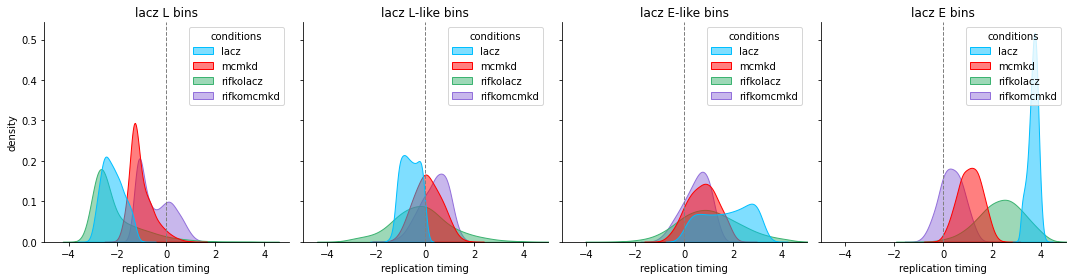

In [27]:
fig, axs = plt.subplots(1, 4, sharey = 'row')
import seaborn as sb

clips = [(-5, 5), (-3, 3), (-5, 5), (-3, 3)]
colors = ['deepskyblue', 'red', 'mediumseagreen', 'mediumpurple']
for ax, domain in zip(axs, domain_names):
    ax.set_title(f'{reference} {domain} bins')
    data = []
    for cond in conditions:
        df = pd.DataFrame(
            {
                'rt': deltas[domain][cond].values,
                'conditions': [cond for i in deltas[domain][cond]]
            }
        )
        data.append(df)

    data = pd.concat(data)
    sb.kdeplot(
        data = data,
        x = 'rt',
        hue = 'conditions',
        bw_adjust = 2,
        ax = ax,
        fill = True,
        alpha = 0.5,
        palette = colors,
        legend = True
    )  

    ax.set_xlim(-5, 5)
    ax.axvline(0, ls = '--', color = 'grey', lw = 1)
    ax.set_xlabel('replication timing')
    ax.set_ylabel('density')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)

fig.set_figwidth(15)
fig.set_figheight(4)
fig.tight_layout()
fig.savefig('rt_bin_change.pdf')